# <center>Exploring the Possibility of Creating New Recipes Using Machine Learning</center>

Cooking recipes are about the combination of flavors. The flavors include the natural flavors of food materials themselves and the flavors of seasoners. Some combinations are delicious, while others can be horrible. In 2016, Kiddon et. al., created coherent recipes given all ingredients and a recipe name utilizing a neural checklist model [1]. In 2019, Bodhisattwa, et. al., built a machine learning model to generate personalized recipes from incomplete input specifications and user histories based on the data collected from food.com [2]. In this work, we are more focusing on utilizing machine learning to summarize the good combination of food natural flavors and seasonings, how to cook them, and to explore the possibility of creating new recipes which are potentially able to get great reviews. We are also going to actually cook the predicted new recipes to verify whether they are delicious. 

### Data Collection and Wrangling

We obtained one set of recipe and review data from kaggle.com [3]. The data set includes a recipe table and a review table, and two of them are linked through RecipeID.  

In [1]:
######################################
# Importing libraries
######################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
import pickle
from collections import defaultdict
import re
from pytimeparse.timeparse import timeparse
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from fuzzywuzzy import process, fuzz
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cluster import KMeans
mpl.rcParams['figure.dpi']=90
plt.rcParams["font.family"] = "arial"
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

We firstly loaded the recipe data, and converting the data set to a pandas DataFrame. The data set is not clean, therefore a direct call of pd.read_csv() will raise errors. We manually parsed the data set line by line.

The data set is delimited by semicolons. According to the header, there should be 10 columns in each observation. However, some observations has a number of items larger than 10. We guessed that users might put some extra semicolons somewhere. We are going to figure it out. 

In [6]:
##########################################################
# Display the column names of the recipes.csv from header
##########################################################
with open('..\\data\\raw\\recipes.csv', 'r') as file:
    recipe_column_name=pd.Series([string.strip() for string in file.readline().split(';')])
recipe_column_name

0     Recipe Name
1        RecipeID
2    Review Count
3    Recipe Photo
4          Author
5    Prepare Time
6       Cook Time
7      Total Time
8     Ingredients
9      Directions
dtype: object

In [7]:
########################################
# Loading recipes.csv
# Reading all the lines in
########################################
lines=[] # A list of lists
with open('..\\data\\raw\\recipes.csv', 'r') as file:
    content=file.readlines()
    for line in content:
        lines.append([item.strip() for item in line.split(';')])
print('Numbers of items in each line after splited by semicolon:')
set([len(ele) for ele in lines])

Numbers of items in each line after splited by semicolon:


{1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23}

In [8]:
##############################################################################################################
# For each observation, there are four conditions:
# length=1: an empty line
# 1<length<10 or the second element is not a number: this content belongs to the previous line
# length=10 and the second element is a number (RecipeID): a perfect observation
# length>10 and the second element is a number (RecipeID): some users wrote extra semicolons somewhere and 
# wrongly separated one column into several items
##############################################################################################################
# Firstly, handle the condition of length=1 and 1<length<10
##############################################################################################################
cleaned_lines=[]
for line in lines:
    if len(line)>=10 and line[1].isnumeric():
        cleaned_lines.append(line)
    elif (len(cleaned_lines)>0 and len(line)<10 and len(line)>1) or (len(cleaned_lines)>0 and len(line)>=2 and not line[1].isnumeric()): 
        cleaned_lines[-1]=cleaned_lines[-1]+line
    else:
        pass
##############################################################################################################
cleaned_lines=[ele for ele in cleaned_lines if ele[0]!='Recipe Name']
print('There are {} recipes observed.'.format(len(cleaned_lines)))

There are 18453 recipes observed.


In [9]:
#####################################################
# Secondly, handle the condition of length>=10
#####################################################
recipes_dict=defaultdict(list)
for line in tqdm.tqdm(cleaned_lines):
    if len(line)>=10:
        assert line[1].isnumeric()
        # To check whether there are semicolons in Recipe Name, and the answer is no.
        assert line[5].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[5]=='X'
        assert line[6].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[6]=='X'
        assert line[7].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[7]=='X'
        assert not line[8].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric()
        # To check whether there are semicolons in Author column and three time columns, and the answer is no.
        # Therefore, the extra semicolons should be in either Ingredients column or Directions column
        # Count how many words in each segment in Ingredients column or Directions column
        word_count=[]
        for i in range(8, len(line)):
            word_count.append(len(line[i].split(' ')))
        # Here we made a simple assumption that the Diretion column should have most number of words 
        # disregarding the first ingredient column.
        # We care more about ingredients than directions, so it's OK to get more words from directions
        # to ingredients
        directions_index=np.argmax(word_count[1:])+9
        ingredients=''.join(line[8:directions_index])
        directions=''.join(line[directions_index:])
        new_line=line[:8]+[ingredients]+[directions]
        line=new_line
        assert len(line)==10
        # Now the column number of each observation is right
        for index, column_name in recipe_column_name.items():
            recipes_dict[column_name].append(line[index])
len(recipes_dict['Recipe Name'])

100%|██████████████████████████████████████████████████████████████████████████| 18453/18453 [00:02<00:00, 8082.70it/s]


18453

In [10]:
####################################################################
# Generating recipe data frame
# It seems that there are duplicated records. If recipe names and authers
# are the same, we consider they are duplicated.
####################################################################
recipes=pd.DataFrame(recipes_dict).drop_duplicates(subset=['Recipe Name', 'Author'], keep='first', ignore_index=True)
print('{} lines of duplicated recipes were dropped.'.format(len(recipes_dict['Recipe Name'])-len(recipes.index)))
recipes.info()

447 lines of duplicated recipes were dropped.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18006 entries, 0 to 18005
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Recipe Name   18006 non-null  object
 1   RecipeID      18006 non-null  object
 2   Review Count  18006 non-null  object
 3   Recipe Photo  18006 non-null  object
 4   Author        18006 non-null  object
 5   Prepare Time  18006 non-null  object
 6   Cook Time     18006 non-null  object
 7   Total Time    18006 non-null  object
 8   Ingredients   18006 non-null  object
 9   Directions    18006 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


In [11]:
################################################################################################################
# Regarding recipes:
# 1. Drop recipes without ingredient information
# 2. Convert RecipeID and review count to ingeters
# 3. Fill missing values with NaN for columns: Recipe Photo, Author, Ingredients, Directions
# 4. Convert Prepare Time, Cook Time, and Total Time to timedelta object, and to fill missing values with NaT
################################################################################################################
recipes_updated=recipes.drop(recipes[recipes['Ingredients']==''].index)
recipes_updated['RecipeID']=recipes['RecipeID'].apply(lambda x: int(x))
recipes_updated['Review Count']=recipes['Review Count'].apply(lambda x: int(x.replace('k', '000')))
recipes_updated['Recipe Photo']=recipes['Recipe Photo'].apply(lambda x: x if x!='X' else np.NaN)
recipes_updated['Author']=recipes['Author'].apply(lambda x: x if x!='X' else np.NaN)
recipes_updated['Prepare Time']=recipes['Prepare Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated['Cook Time']=recipes['Cook Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated['Total Time']=recipes['Total Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17175 entries, 0 to 18005
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Recipe Name   17175 non-null  object         
 1   RecipeID      17175 non-null  int64          
 2   Review Count  17175 non-null  int64          
 3   Recipe Photo  17175 non-null  object         
 4   Author        17175 non-null  object         
 5   Prepare Time  11843 non-null  timedelta64[ns]
 6   Cook Time     9889 non-null   timedelta64[ns]
 7   Total Time    11937 non-null  timedelta64[ns]
 8   Ingredients   17175 non-null  object         
 9   Directions    17175 non-null  object         
dtypes: int64(2), object(5), timedelta64[ns](3)
memory usage: 1.4+ MB


The second step is loading the review data, and converting the data set to a pandas DataFrame. The data set is also not clean, therefore a direct call of pd.read_csv() will raise errors either. We manually parsed the data set line by line and did the same operation as for recipes.

In [12]:
##########################################################
# Display the column names of the reviews.csv from header
##########################################################
with open('..\\data\\raw\\reviews.csv', 'r') as file:
    review_column_name=pd.Series([string.strip() for string in file.readline().split(';')])
review_column_name

0     RecipeID
1    profileID
2         Rate
3      Comment
dtype: object

In [13]:
########################################
# Loading reviews.csv
# Reading all the lines in
########################################
lines_review=[] # A list of lists
with open('..\\data\\raw\\reviews.csv', 'r') as file:
    content=file.readlines()
    for line in tqdm.tqdm(content):
        lines_review.append([item.strip() for item in line.split(';')])
print('Numbers of items in each line after splited by semicolon:')
set([len(ele) for ele in lines_review])

100%|████████████████████████████████████████████████████████████████████| 3270508/3270508 [00:13<00:00, 249353.60it/s]


Numbers of items in each line after splited by semicolon:


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [14]:
##############################################################################################################
# For each observation, there are four conditions:
# length=1: an empty line
# 1<length<4 or the first item is not a number (RecipeID): this content belongs to the previous line
# length=4 and the first item is a number (RecipeID): a perfect observation
# length>4 and the first item is a number (RecipeID): some users wrote extra semicolons somewhere and wrongly 
# separated one column into several items
##############################################################################################################
# Firstly, handle the condition of length=1 and 1<length<4
##############################################################################################################
cleaned_lines_review=[]
for line in tqdm.tqdm(lines_review):
    if len(line)>=4 and line[0].isnumeric():
        cleaned_lines_review.append(line)
    elif (len(cleaned_lines_review)>0 and len(line)<4 and len(line)>1) or (len(cleaned_lines_review)>0 and len(line)>=1 and not line[0].isnumeric()):
        cleaned_lines_review[-1]=cleaned_lines_review[-1]+line
    else:
        pass
##############################################################################################################
cleaned_lines_review=[ele for ele in cleaned_lines_review if ele[0]!='RecipeID']
print('There are {} reviews observed.'.format(len(cleaned_lines_review)))

100%|████████████████████████████████████████████████████████████████████| 3270508/3270508 [00:09<00:00, 336038.97it/s]


There are 1578721 reviews observed.


In [15]:
#####################################################
# Secondly, handle the condition of length>=4
#####################################################
reviews_dict=defaultdict(list)
for line in tqdm.tqdm(cleaned_lines_review):
    if len(line)>=4:
        assert line[0].isnumeric()
        # To check whether all the RecipeID are numbers, and the answer is YES.
        assert line[1].isnumeric()
        # To check whether all the PrefileID are numbers, and the answer is YES.
        assert line[2].isnumeric()
        # To check whether all the rates are numbers, and the answer is YES.
        # Therefore, there is only one place where users wrote extra semicolons in: comment section
        new_line=line[:3]+[''.join(line[3:])]
        line=new_line
        assert len(line)==4
        # Now the column number of each observation is right
        for index, column_name in review_column_name.items():
            reviews_dict[column_name].append(line[index])
len(reviews_dict['RecipeID'])

100%|█████████████████████████████████████████████████████████████████████| 1578721/1578721 [00:40<00:00, 38938.41it/s]


1578721

In [16]:
####################################################################
# Generating reviews data frame
# It seems that there are duplicated records. If all the columns
# are the same, we consider they are duplicated.
####################################################################
reviews=pd.DataFrame(reviews_dict).drop_duplicates(keep='first', ignore_index=True)
print('{} lines of duplicated reviews were dropped.'.format(len(reviews_dict['RecipeID'])-len(reviews.index)))
print('{} lines left.'.format(len(reviews.index)))
reviews.info()

7894 lines of duplicated reviews were dropped.
1570827 lines left.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570827 entries, 0 to 1570826
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RecipeID   1570827 non-null  object
 1   profileID  1570827 non-null  object
 2   Rate       1570827 non-null  object
 3   Comment    1570827 non-null  object
dtypes: object(4)
memory usage: 47.9+ MB


In [17]:
################################################################################################################
# Regarding reviews:
# 1. Drop reviews without recipeID
# 2. Convert RecipeID, review count, and rate to ingeters
# 3. Fill missing values with NaN for Comments
################################################################################################################
reviews_updated=reviews[~reviews['RecipeID'].isna()]
for name in reviews.columns:
    reviews_updated[name]=reviews[name].apply(lambda x: int(x) if type(x)==str and x.isnumeric() else x)
reviews_updated.loc[reviews['Comment']=='', 'Comment']=np.NaN
reviews_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570827 entries, 0 to 1570826
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RecipeID   1570827 non-null  int64 
 1   profileID  1570827 non-null  int64 
 2   Rate       1570827 non-null  int64 
 3   Comment    1570642 non-null  object
dtypes: int64(3), object(1)
memory usage: 59.9+ MB


In [18]:
####################################################################################
# Now let's compare the two tables: how many common recipes do they have?
####################################################################################
print('There are {} recipes in recipes data set, and {} recipes in reviews data set.'.format(
    len(recipes_updated.groupby('RecipeID').count().index),
    len(reviews_updated.groupby('RecipeID').count().index)
))
print('And there are {} recipes in both data sets.'.format(
    len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values)))
))

There are 17175 recipes in recipes data set, and 9037 recipes in reviews data set.
And there are 8908 recipes in both data sets.


In [19]:
###################################################################
# Calculate the ratio of recipes with reviews in total recipes
###################################################################
print('There are {} valid recipes, and {} recipes ({:.2f}%) have reviews.'.format(
    len(recipes_updated.groupby('RecipeID').count().index), 
    len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values))), 
    float(len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values))))/float(len(recipes_updated.groupby('RecipeID').count().index))*100
))

There are 17175 valid recipes, and 8908 recipes (51.87%) have reviews.


In [20]:
###############################################################################
# We are going to investigate these 8908 recipes
# Subset the data sets 
###############################################################################
common_ID=list(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values)))
recipes_updated_2=recipes_updated[recipes_updated['RecipeID'].isin(common_ID)]
reviews_updated_2=reviews_updated[reviews_updated['RecipeID'].isin(common_ID)]
assert len(recipes_updated_2['RecipeID'].index)==recipes_updated_2['RecipeID'].nunique()
assert recipes_updated_2['RecipeID'].nunique()==reviews_updated_2['RecipeID'].nunique()
recipes=recipes_updated_2
reviews=reviews_updated_2

Only a little more than half of the recipes have reviews. We have to give up the recipes which don't have reviews because we don't know how good these recipes are.

### Exploratory Data Analysis of Recipe and Review 

Now we are goint to take a look at the recipe and review data through exploratory data analysis. 

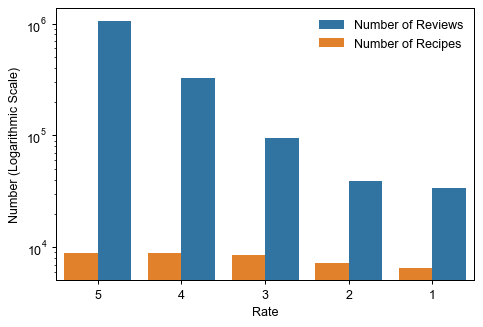

In [18]:
####################################################################################
# The rate is from 1 to 5. How many reviews and recipes fall in each category?
####################################################################################
data=pd.DataFrame({'Rate':[5, 4, 3, 2, 1],
                  'Number of Reviews': list(reviews.groupby(by='Rate')['RecipeID'].count().sort_index(ascending=False)),
                  'Number of Recipes': list(reviews.groupby(by='Rate')['RecipeID'].nunique().sort_index(ascending=False))
                  })

fig, ax=plt.subplots(1, 1)
sns.barplot(x='Rate', y='Value', hue='Variable', data=data.melt(id_vars='Rate').rename(columns=str.title), ax=ax)
ax.set_yscale('log')
ax.set_xlim(4.5, -0.5)
ax.set_xlabel('Rate')
ax.set_ylabel('Number (Logarithmic Scale)')
plt.legend(frameon=False)
plt.show()

It's clear that the qualities of recipes are quite evenly distributed. However, better recipes are more popular and attract more reviewers. Therefore we need a score to evaluate each recipe considering not only how many stars but also how many reviewers, so we can evaluate both quality and popularity by one score.    

In [19]:
############################################################################################
# What are the scores of recipes look like?
############################################################################################
# Considering using the table below to calculate a score for each recipe
# =========================================================
# Star     |      5         4       3       2        1
# ---------------------------------------------------------
# Weight   |    100        75      50      25        0
# ---------------------------------------------------------
# Meaning  | Very Good    Good    Fair   Poor   Very Poor
# =========================================================
############################################################################################
recipe_ID=list(reviews.groupby(by=['RecipeID'])['profileID'].count().index)
recipe_name=[]
for id in recipe_ID:
    recipe_name.append(recipes.loc[recipes['RecipeID']==id, 'Recipe Name'].values[0])
assert len(recipe_ID)==len(recipe_name)

In [20]:
#######################################################################################################################
# Calculate score for each recipe
# Score=100*(number of 5 star)+75*(number of 4 star)+50*(number of 3 star)+25*(number of 2 star)+0*(number of 1 star)
# For each recipe, calculate how many 5 star, 4 star, 3 star, 2 star, and 1 star it got
#######################################################################################################################
score=[]
star5=[]
star4=[]
star3=[]
star2=[]
star1=[]
ratings=reviews.groupby(['RecipeID', 'Rate'])['Rate'].count()
for id in tqdm.tqdm(recipes['RecipeID']):
    dataframe=ratings.loc[pd.IndexSlice[id, 1:5], :].rename('Count')
    inner_index=dataframe.index.get_level_values(level=1)
    inner_index_weight=pd.Series(inner_index).replace({5:100, 4:75, 3:50, 2:25, 1:0})
    this_score=0
    this_star=[0,0,0,0,0] # star 5 to star 1
    for index, weight in zip(inner_index, inner_index_weight):
        count_value=dataframe[dataframe.index.get_level_values(level=1)==index].values[0]
        this_score=this_score+weight*count_value
        if index==5:
            this_star[0]=count_value
        elif index==4:
            this_star[1]=count_value
        elif index==3:
            this_star[2]=count_value
        elif index==2:
            this_star[3]=count_value
        else:
            this_star[4]=count_value
    score.append(this_score)
    star5.append(this_star[0])
    star4.append(this_star[1])
    star3.append(this_star[2])
    star2.append(this_star[3])
    star1.append(this_star[4])
assert len(score)==len(recipe_ID)==len(recipe_name)==len(star5)==len(star4)==len(star3)==len(star2)==len(star1)

100%|█████████████████████████████████████████████████████████████████████████████| 8908/8908 [01:04<00:00, 138.60it/s]


In [21]:
############################################################################################
# Build the recipe score data frame
############################################################################################
recipe_score_data=pd.DataFrame({
    'Recipe Name': recipe_name,
    'Score': score,
    'Star 5': star5,
    'Star 4': star4,
    'Star 3': star3,
    'Star 2': star2,
    'Star 1': star1
}, index=recipe_ID)
recipe_score_data.index.name='RecipeID'
recipe_score_data.sort_values(by='Score', ascending=False).head(20)

,Recipe Name,Score,Star 5,Star 4,Star 3,Star 2,Star 1
RecipeID,,,,,,,
13838,Sugar Coated Pecans Recipe,97000,933,41,11,3,2
24952,Caramel Popcorn Recipe,95725,905,61,8,10,6
13436,Italian Sausage Soup with Tortellini Recipe,95625,890,76,16,5,3
20669,Double Tomato Bruschetta Recipe,95250,878,89,12,7,4
19163,Luscious Slush Punch Recipe,95250,883,82,14,4,7
17690,Sweet Dinner Rolls Recipe,95075,883,75,20,6,6
19484,Grilled Marinated Shrimp Recipe,94950,874,84,19,12,1
23822,Pumpkin Gingerbread Recipe,94950,861,102,23,2,2
20156,Clone of a Cinnabon Recipe,94950,886,69,21,5,9


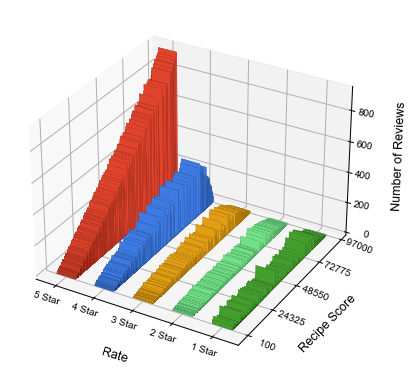

In [22]:
############################################################################################
# Plot 3-D bar
############################################################################################
data=recipe_score_data.sort_values(by='Score', ascending=False)[:]
#==============================================================
fig=plt.figure()
ax=Axes3D(fig)
lx=5          
ly=len(data.index)
xpos=np.arange(0,lx,1)    
ypos=data['Score']
xpos, ypos=np.meshgrid(xpos-0.2, ypos)
xpos=xpos.flatten()   
ypos=ypos.flatten()
zpos=np.zeros(lx*ly)

dx=0.5*np.ones_like(zpos)
dy=dx.copy()
dz=data[['Star 5', 'Star 4', 'Star 3', 'Star 2', 'Star 1']].values.flatten()
cs=[(1, 0.3, 0.2), (0.27,0.54,1), (1, 0.7, 0.09), (0.5, 1, 0.6), (0.3, 0.7, 0.2)]*ly
ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)
ax.set_xlabel('Rate', rotation=(-17))
ax.set_ylabel('Recipe Score')
ax.set_zlabel('Number of Reviews')
ax.set_xticks([i for i in range(5)])
ax.set_xticklabels(rotation=(-17), fontsize=8, va='bottom', ha='center', 
                   labels=['5 Star', '4 Star', '3 Star', '2 Star', '1 Star'])
ax.set_yticks([i+2000 for i in np.linspace(data.iloc[0, 1], data.iloc[-1, 1], num=5, endpoint=True)])
y_labels=['  {:.0f}'.format(x) for x in np.linspace(data.iloc[0, 1], data.iloc[-1, 1], num=5, endpoint=True)] 
ax.set_yticklabels(rotation=(-21), fontsize=8, va='bottom', ha='center', labels=y_labels)
ax.set_zticks([x for x in np.linspace(0, 800, num=5, endpoint=True)])
ax.set_zticklabels(rotation=(-10), fontsize=8, va='top', ha='right', labels=[0, 200, 400, 600, 800])
plt.show()

It seems that 5 star and 4 star reviews have occupied the majority of the total reviews. The recipes are distributed in a wide range of recipe score (from 100 to 97000), indicating a large variation of quality and popularity level of the recipes. The recipe score is a good indicator for our study.

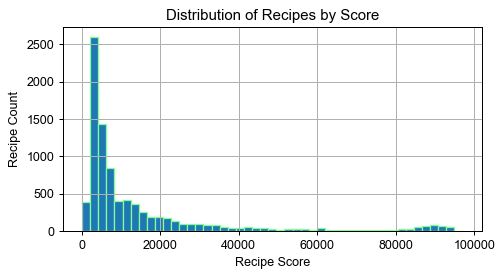

In [25]:
#################################################
# Distribution of scores
#################################################
fig, ax=plt.subplots(1, 1, figsize=(6,3))
recipe_score_data['Score'].hist(bins=int(np.sqrt(len(recipe_score_data.index))/2), edgecolor=(0.5, 1, 0.6))
ax.set_xlabel('Recipe Score')
ax.set_ylabel('Recipe Count')
ax.set_title('Distribution of Recipes by Score')
plt.show()

The distribution of recipes is not even. The majority of the recipes are not good. Only a small portion of recipes have better quality (score of which is larger than 80,000). Interestly, the number of fair recipes is even less (score of which is in a range of 40,000 to 80,000). Selection bias maybe kick in: people would like to give reviews on really good recipes or really bad recipes. But it doesn't affect our investigation, because we are only interested in really good recipes. 

In [26]:
#################################################
# Save the cleaned data
#################################################
with open('..\\data\\processed\\recipes.pkl', 'wb') as file:
    pickle.dump(recipes, file)
with open('..\\data\\processed\\reviews.pkl', 'wb') as file:
    pickle.dump(reviews, file)
with open('..\\data\\processed\\scores.pkl', 'wb') as file:
    pickle.dump(recipe_score_data, file)

### Pre-processing and Training

#### Build One-hot Encoding Ingredients Data Frame

Our interest is to find out what combination of food materials and/or seasoners would lead to good recipes. Therefore we need to extract the information about the food materials and seasoners from recipes, and figure out what good or bad combinations look like.

In [27]:
##################################################
# Load the cleaned data
##################################################
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\reviews.pkl', 'rb') as file:
    reviews=pickle.load(file)
with open('..\\data\\processed\\scores.pkl', 'rb') as file:
    scores=pickle.load(file)
print('Dataframe recipes: \t{} rows \t{} columns.'.format(recipes.shape[0], recipes.shape[1]))
print('Dataframe reviews: \t{} rows \t{} columns.'.format(reviews.shape[0], reviews.shape[1]))
print('Dataframe scores: \t{} rows \t{} columns.'.format(scores.shape[0], scores.shape[1]))

Dataframe recipes: 	8908 rows 	10 columns.
Dataframe reviews: 	1554110 rows 	4 columns.
Dataframe scores: 	8908 rows 	7 columns.


Not all the words in the ingredients column are actual ingredients. Some words like measure words or verbs are not the ones we need. One possible approach for selecting these not-ingredient words out is based on an assumption that these words may appear with higher frequency. 

In [28]:
##########################################################
# Find higher frequcency words in ingredients column
##########################################################
words0=recipes.loc[:, 'Ingredients'].sum()
words1=re.sub('[\(\[].*?[\)\]]', '', words0) # Remove content in parentheses
words2=re.sub(r'[0-9]+', '', words1).replace('/', '').replace('**', ' ').replace(',', ' ').replace('.', ' ').replace('-', ' ')
words=[word for word in words2.split(' ') if word]
words_frequency=pd.DataFrame({'Words': words})['Words'].value_counts()
print('Found {} words from ingredients column.'.format(len(words_frequency)))

Found 4154 words from ingredients column.


Apparently some of the high-frequency words are still ingredients but a lot more are not. We marked those top 200 high-frequency words which are not ingredients, together with some other common not-ingredient words, to build a list of non-ingredient words.

In [29]:
words_frequency[:200].to_dict().keys()

dict_keys(['cup', 'teaspoon', 'cups', 'and', 'sugar', 'chopped', 'tablespoons', 'salt', 'white', 'ground', 'butter', 'flour', 'pepper', 'to', 'tablespoon', 'all', 'can', 'purpose', 'cheese', 'teaspoons', 'cream', 'baking', 'a', 'oil', 'powder', 'package', 'onion', 'water', 'vanilla', 'eggs', 'milk', 'garlic', 'extract', 'fresh', 'the', 'chicken', 'sliced', 'black', 'large', 'dried', 'taste', 'egg', 'brown', 'sauce', 'pound', 'in', 'minced', 'green', 'of', 'shredded', 'soda', 'mix', 'vegetable', 'diced', 'softened', 'juice', 'until', 'chocolate', 'ounces', 'drained', 'lemon', 'cinnamon', 'into', 'cloves', 'peeled', 'for', 'olive', 'beef', 'red', 'pounds', 'dry', 'bowl', 'oven', 'grated', 'tomatoes', 'condensed', 'medium', 'crushed', 'frozen', 'F', 'degrees', 'with', 'soup', "confectioners''", 'packed', 'inch', 'onions', 'melted', 'or', 'bell', 'cans', 'In', 'celery', 'cut', 'boneless', 'Cheddar', 'Add', 'sour', 'tomato', 'beaten', 'bread', 'potatoes', 'pinch', 'broth', 'parsley', 'chips

In [23]:
###########################################
# A list of non-ingredient words
###########################################
non_ingredient_words=['cup', 'teaspoon', 'cups', 'and', 'chopped', 'tablespoons', 
                      'white', 'ground', 'to', 'tablespoon',
                      'can', 'teaspoons', 'a', 
                      'package', 'water', 'fresh', 'the', 'sliced', 'large', 'dried', 
                      'taste', 'pound', 'in', 'green', 'of',
                      'shredded', 'mix', 'diced', 'softened', 'until', 'ounces', 'drained', 'into',
                      'peeled', 'for', 'pounds', 'dry', 'bowl',
                      'oven', 'grated', 'medium', 'condensed', 'crushed', 'frozen',
                      'F', 'degrees', 'with', 'packed', 'inch', 'melted', 'or', 'bell', 'cans', 'In', 'cut', 'boneless',
                      'Add', 'sour', 'beaten', 'pinch', 'skinless', 'heat', 'small',
                      'cubed', 'minutes', 'together',
                      'shortening', 'halves', 'cooked', 'whole',   
                      'thawed', 'over', 'heavy', 'slices',
                      'unsweetened', 'packages', 'finely', 'pieces', 'seasoning', 'hot', 'style', 'boil', 'container', 
                      'lightly', 'instant', 'pot', 'Italian', 
                      'prepared', 'thinly', 'half', 'light', 
                      'pan', 'skillet', 'cook', 'flavored', 
                      'combine', 'divided', 'yellow', 
                      'jar', 'whipped', 'topping', 'lean',
                      'uncooked', 'Combine', 'recipe', 
                      'sweet', 'Stir', 'warm', 'active', 'room', 'temperature', 'ounce', 'gallon',
                      'other', 'drops', 'Sift', 'bottle', 'soaked', 'hours', 'hour', 'about', 'minute', 'gather', 'it']

In [31]:
#############################################################
# Build a one-hot encoding data frame named "ingredients"
# RecipeID, and all the other columns are ingredient names
# with zero(0) standing for no-use for this ingredient
# and with one(1) standing for use of this ingredient
#############################################################
ingredients_list=[]
ingredients0=recipes[['RecipeID', 'Ingredients']].reset_index()
for row in tqdm.tqdm(ingredients0['Ingredients'].values):
    string1=re.sub(r'[\(\[].*?[\)\]]', '', row)
    string2=re.sub(r'[0-9]+', '', string1).replace('/', '').replace('**', ' ** ').replace(',', ' , ').replace('.', ' . ')
    string3=' '.join([word for word in string2.split(' ') if word not in non_ingredient_words]).strip()
    ingreds0=[word for word in [word.strip() for word in string3.split('**')] if word]
    ingreds1=[words for words in ingreds0 if len(words.split(' '))<=6]
    ingreds=[word for word in [words.replace(',', '').replace("'", "").strip() for words in ingreds1] if word]
    ingredients_list.extend(ingreds)
ingredients_list=[ing.replace('*', '').strip() for ing in list(set(ingredients_list))]
print('Found {} ingredients.'.format(len(ingredients_list)))

100%|████████████████████████████████████████████████████████████████████████████| 8908/8908 [00:01<00:00, 4458.43it/s]

Found 4502 ingredients.


In [32]:
#####################################################################################
# Find typos or very similiar ones and combine them (string comparison ratio >= 95%)
#####################################################################################
Dict=defaultdict(list)
Dict[ingredients_list[0]].append(ingredients_list[0])
for index, item in tqdm.tqdm(enumerate(ingredients_list, start=1)):
    flag=False
    for key, value in Dict.items():
        if fuzz.WRatio(item, value[0])>=95:
            Dict[key].append(item)
            flag=True
            break
    if not flag:
        Dict[item].append(item)
print('Found {} different ingredients based on 95% string similarity.'.format(len(Dict.keys())))
count=0
for key, value in Dict.items():
    if len(value)>1:
        print(key, ': ', value)
        count+=1
        if count>10: break

4502it [14:27,  5.19it/s]

Found 3542 different ingredients based on 95% string similarity.
FOO YUNG SAUCE :  ['FOO YUNG SAUCE', 'FOO YUNG SAUCE']
beef sirloin steaks :  ['beef sirloin steaks', 'beef sirloin steak', 'beef sirloin tip steaks', 'beef top sirloin steaks']
quart orange sherbet :  ['quart orange sherbet', 'orange sherbet']
Icing :  ['Icing', 'Icing:']
red kidney beans :  ['red kidney beans', 'dark red kidney beans', 'kidney beans']
TOPPING: :  ['TOPPING:', 'Topping:', 'TOPPING']
fusilli  pasta :  ['fusilli  pasta', 'fusilli pasta']
confectioners sugar   dusting :  ['confectioners sugar   dusting', 'confectioners sugar dusting']
peppers   halved seeded :  ['peppers   halved seeded', 'jalapeno peppers   seeded halved', 'red peppers   halved seeded', 'peppers   seeded']
butterPreheat   . :  ['butterPreheat   .', 'butterPreheat', 'butterPreheat    .']
marshmallow :  ['marshmallow', 'marshmallows']


In [33]:
###############################################################
# Build ingredients data frame
###############################################################
ingredients1=ingredients0[['RecipeID', 'Ingredients']].copy()
###############################################################
# Construct whole data frame with all zeros
###############################################################
for key, value in tqdm.tqdm(Dict.items()):
    ingredients1[key]=0
ingredients1.iloc[:10, :5]

100%|█████████████████████████████████████████████████████████████████████████████| 3542/3542 [00:11<00:00, 319.67it/s]


,RecipeID,Ingredients,FOO YUNG SAUCE,wasabi paste,beef sirloin steaks
0,7000,2 (.25 ounce) packages active dry yeast**3/4 c...,0,0,0
1,7001,'3 cups all-purpose flour**1 1/2 teaspoons sal...,0,0,0
2,7003,3 cups all-purpose flour**3 eggs**2 cups white...,0,0,0
3,7009,1/3 cup shortening**1 cup hot water**1 cup pac...,0,0,0
4,7010,2 cups milk**1/2 cup warm water (110 degrees F...,0,0,0
5,7011,1 tablespoon active dry yeast**1 teaspoon whit...,0,0,0
6,7013,1 cup margarine**1 1/4 cups white sugar**1 egg...,0,0,0
7,7245,2 1/4 teaspoons active dry yeast**1/2 teaspoon...,0,0,0
8,7246,2 cups white sugar**2 cups sifted all-purpose ...,0,0,0
9,7251,1/2 cup butter**1/2 cup vegetable oil**1 3/4 c...,0,0,0


In [34]:
###########################################################
# Check Ingredients column and fill in the numeric columns
###########################################################
ingredients2=ingredients1.copy()
for index, row in tqdm.tqdm(ingredients2.iterrows()):
    string=row.loc['Ingredients']
    string1=re.sub(r'[\(\[].*?[\)\]]', '', string)
    string2=re.sub(r'[0-9]+', '', string1).replace('/', '').replace('**', ' ** ').replace(',', ' , ').replace('.', ' . ')
    string3=' '.join([word for word in string2.split(' ') if word not in non_ingredient_words]).strip()
    ingreds0=[word for word in [word.strip() for word in string3.split('**')] if word]
    ingreds1=[words for words in ingreds0 if len(words.split(' '))<=6]
    ingreds=[word.replace('*', '').strip() for word in [words.replace(',', '').replace("'", "").strip() for words in ingreds1] if word]
    for ing in ingreds:
        for key, value in Dict.items():
            if ing in value:
                ingredients2.iloc[index, ingredients2.columns.get_loc(key)]=1
                break
ingredients=ingredients2.drop(columns=['Ingredients'])
with open('..\\data\\processed\\ingredients.pkl', 'wb') as file:
    pickle.dump(ingredients, file)
print('There are {} rows and {} columns in the ingredients data frame.'.format(ingredients.shape[0], ingredients.shape[1]))

8908it [01:34, 94.48it/s] 


There are 8908 rows and 3543 columns in the ingredients data frame.


There is a question: how many ingredients one recipe is using? When we build a new recipe, we don't want to use too many kinds of ingredients or too few. We use histograms and kernel density estimation (KDE) to describe the number of ingredients in existing recipes. 

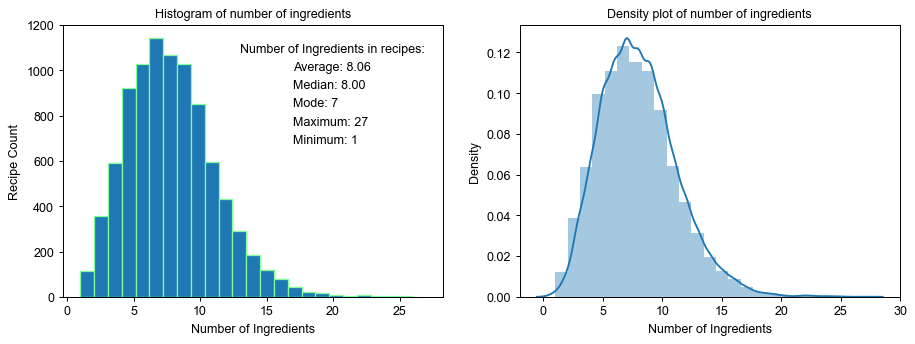

In [35]:
####################################################################
# Find the information about numbers of ingredients for each recipe
####################################################################
with open('..\\data\\processed\\ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
#################################################################
ingredients['Ingredient Count']=ingredients.iloc[:, 1:].sum(axis=1)
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(ingredients['Ingredient Count'], bins=25, edgecolor=(0.5,1,0.6))
ax1.set_xlabel('Number of Ingredients')
ax1.set_ylabel('Recipe Count')
ax1.set_title('Histogram of number of ingredients', fontsize=10)
ax1.text(13, 1080, 'Number of Ingredients in recipes:')
ax1.text(17, 1000, 'Average: {:.2f}'.format(ingredients['Ingredient Count'].mean()))
ax1.text(17, 920, 'Median: {:.2f}'.format(ingredients['Ingredient Count'].median()))
ax1.text(17, 840, 'Mode: {}'.format(ingredients['Ingredient Count'].mode().values[0]))
ax1.text(17, 760, 'Maximum: {}'.format(ingredients['Ingredient Count'].max()))
ax1.text(17, 680, 'Minimum: {}'.format(ingredients['Ingredient Count'].min()))
###################################################################
sns.distplot(ingredients['Ingredient Count'], hist=True, kde=True, bins=25, ax=ax2)
ax2.set_title('Density plot of number of ingredients', fontsize=10)
ax2.set_xlabel('Number of Ingredients')
###################################################################
plt.show()

It seems that most of the recipes have 7~8 ingredients. 

Now we have made a one-hot encoding ingredients data frame with ingredients as column names. This data frame can help us with the question about the underlying relationship between the combination of ingredients and the quality of recipes. 

#### Principal Component Analysis of One-hot Encoding Ingredients Data Frame

The ingredients data frame contains 3542 ingredients. For each recipe, in average only 7~8 ingredients have a value of 1, and the rest of ingredients have a value of 0. Therefore the data frame is probably suffering from curse of dimensions. We are going to use principal component analysis (PCA) to evaluate the situation. 

Among all of these recipes, which are good ones and which are bad ones? In order to simplify the modeling, we may convert a regression problem to a classification problem. We can label recipes to be good ones (score >= 40000) and bad ones (score < 40000), and mark 1 for the good ones and 0 for the bad ones. The good recipes and the bad recipes are also shown in PCA analysis.

In [5]:
###################################################
# PCA analysis of the one-hot encoding dataframe
###################################################
with open('..\\data\\processed\\ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\reviews.pkl', 'rb') as file:
    reviews=pickle.load(file)
with open('..\\data\\processed\\scores.pkl', 'rb') as file:
    scores=pickle.load(file)
ingredients1=ingredients.set_index('RecipeID').merge(scores[['Score']], how='left', on='RecipeID')
ingredients1['Label']=ingredients1['Score'].apply(lambda x: 1 if x>=40000 else 0)
ingredients2=ingredients1.drop(columns=['Score'])
pca=PCA().fit(ingredients2.drop(columns=['Label']))
pca_x=pca.transform(ingredients2.drop(columns=['Label']))

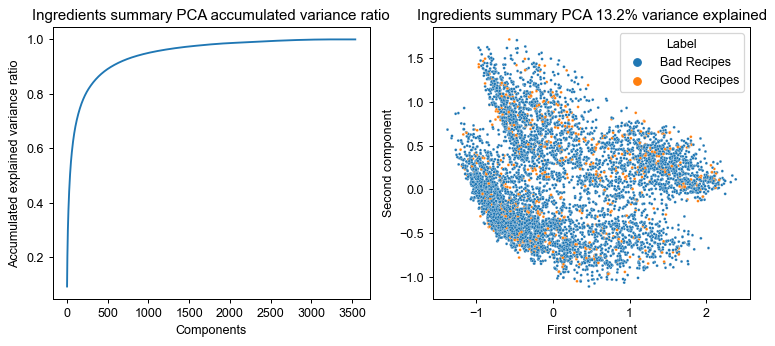

In [13]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 4))
_=ax1.plot(pca.explained_variance_ratio_.cumsum())
_=ax1.set_xlabel('Components')
_=ax1.set_ylabel('Accumulated explained variance ratio')
_=ax1.set_title('Ingredients summary PCA accumulated variance ratio')
_=sns.scatterplot(x=pca_x[:, 0], y=pca_x[:, 1], s=5, hue=ingredients2['Label'].apply(lambda x: 'Good Recipes' if x==1 else 'Bad Recipes'), ax=ax2)
_=ax2.set_xlabel('First component')
_=ax2.set_ylabel('Second component')
_=ax2.set_title('Ingredients summary PCA {:.1f}% variance explained'.format(100*pca.explained_variance_ratio_.cumsum()[1]))
plt.show()

It costs over 500 components to reach 90% variance explained, and the first two components can only explain 13.2% variance. It seems that the variance cannot be concentrated into several principal components. We have to go through higher dimensions to get our questions answered. Also we noticed that, from the first two components, all the recipes naturally separate into several clusters. It is intuitive because different regions of the world have different type of food styles, and recipes in same regions are similar. Also the good recipes are almost evenly distributed in each clusters from the first two components of PCA analysis, which will bring difficulties to the next supervised learning. We need more features to make the good recipes get together.

#### Build One-hot Encoding Cooking methods Data Frame

Good food needs both unique combination of recipes and appropriate cooking methods. Next step we are going to extract key words from the Directions as features to build one-hot encoding cooking methods data frame.

In [56]:
##################################################
# Load the clean data
##################################################
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
##########################################################
# Extract words from Directions
##########################################################
words0=recipes.loc[:, 'Directions'].sum()
words1=re.sub('[\(\[].*?[\)\]]', '', words0) # Remove content in parentheses
words2=re.sub(r'[0-9]+', '', words1).replace('/', '').replace('**', ' ').replace(',', ' ').replace('.', ' ').replace('-', ' ')
words=[word for word in words2.split(' ') if word]
#########################################################################
# Find top 200 high frequency words
#########################################################################
words_frequency=pd.DataFrame({'Words': words})['Words'].value_counts()
print('Found {} words from Directions column.'.format(len(words_frequency)))

Found 7163 words from Directions column.


In [122]:
cooking_methods0=list(set(list(words_frequency[:1000].to_dict().keys()))-set(ingredients.columns)-set(non_ingredient_words))
pd.DataFrame({'Words': cooking_methods0}).to_csv('..\\data\\processed\\cooking_methods0.csv')
cooking_methods1=pd.read_csv('..\\data\\processed\\cooking_methods.csv')
cooking_methods2=cooking_methods1[cooking_methods1['Is method']=='y']
cooking_methods={word: [word] for word in list(set(cooking_methods2['Words'].apply(str.lower)))}

In [118]:
###############################################################
# Build cooking methods data frame
###############################################################
methods1=recipes[['RecipeID', 'Directions']].copy().reset_index().drop(columns=['index'])
###############################################################
# Construct whole data frame with all zeros
###############################################################
for key, value in cooking_methods.items():
    methods1[key]=0
methods1.iloc[:10, :10]

,RecipeID,Directions,mash,spray,steam,mashed,creamed,aluminum,wax,floured
0,7000,"Dissolve yeast in warm water.**Stir in sugar, ...",0,0,0,0,0,0,0,0
1,7001,'Preheat oven to 350 degrees F (175 degrees C)...,0,0,0,0,0,0,0,0
2,7003,Preheat oven to 350 degrees F (175 degrees C)....,0,0,0,0,0,0,0,0
3,7009,Dissolve brown sugar in 1 cup hot water. Add ...,0,0,0,0,0,0,0,0
4,7010,the dough should be smooth and glossy in appea...,0,0,0,0,0,0,0,0
5,7011,"'Mix together yeast, 1 teaspoon sugar, 1/4 cup...",0,0,0,0,0,0,0,0
6,7013,Preheat oven to 350 degrees F (175 degrees C)....,0,0,0,0,0,0,0,0
7,7245,this should take about 1 hour. Punch down the ...,0,0,0,0,0,0,0,0
8,7246,Mix together the buttermilk with the baking so...,0,0,0,0,0,0,0,0
9,7251,"Cream together butter or margarine, vegetable ...",0,0,0,0,0,0,0,0


In [119]:
###########################################################
# Check Directions column and fill in the numeric columns
###########################################################
methods2=methods1.copy()
for index, row in tqdm.tqdm(methods2.iterrows()):
    string=row.loc['Directions']
    string1=re.sub(r'[\(\[].*?[\)\]]', '', string)
    string2=re.sub(r'[0-9]+', '', string1).replace('/', '').replace('**', ' ** ').replace(',', ' , ').replace('.', ' . ')
    string3=' '.join([word for word in string2.split(' ') if word not in non_ingredient_words]).strip()
    words=[word.lower() for word in [word.strip() for word in string3.split(' ')] if word]
    for w in words:
        for key, value in cooking_methods.items():
            if w in value:
                methods2.iloc[index, methods2.columns.get_loc(key)]=1
                break
methods=methods2.drop(columns=['Directions']).set_index('RecipeID')
with open('..\\data\\processed\\methods.pkl', 'wb') as file:
    pickle.dump(methods, file)
print('There are {} rows and {} columns in the methods data frame.'.format(methods.shape[0], methods.shape[1]))

8908it [00:22, 390.58it/s]

There are 8908 rows and 37 columns in the methods data frame.


#### Principal Component Analysis of One-hot Encoding Ingredients and Cooking Methods Data Frame

In [123]:
with open('..\\data\\processed\\ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\reviews.pkl', 'rb') as file:
    reviews=pickle.load(file)
with open('..\\data\\processed\\scores.pkl', 'rb') as file:
    scores=pickle.load(file)
with open('..\\data\\processed\\methods.pkl', 'rb') as file:
    methods=pickle.load(file)
ingredients_methods0=ingredients.set_index('RecipeID').merge(methods, how='left', on='RecipeID')
ingredients_methods1=ingredients_methods0.merge(scores[['Score']], how='left', on='RecipeID')
ingredients_methods1['Label']=ingredients_methods1['Score'].apply(lambda x: 1 if x>=40000 else 0)
ingredients_methods2=ingredients_methods1.drop(columns=['Score'])
pca=PCA().fit(ingredients_methods2.drop(columns=['Label']))
pca_x=pca.transform(ingredients_methods2.drop(columns=['Label']))

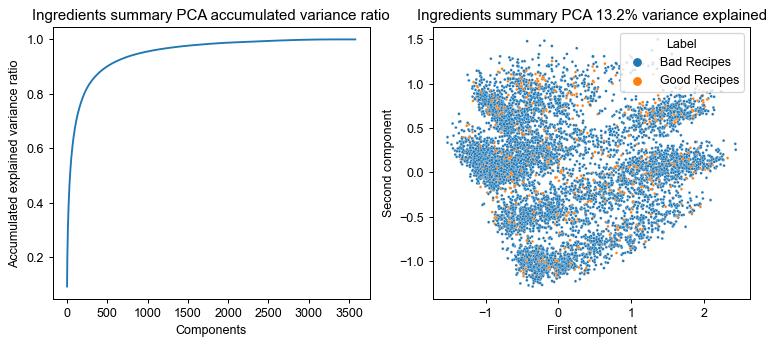

In [124]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 4))
_=ax1.plot(pca.explained_variance_ratio_.cumsum())
_=ax1.set_xlabel('Components')
_=ax1.set_ylabel('Accumulated explained variance ratio')
_=ax1.set_title('Ingredients summary PCA accumulated variance ratio')
_=sns.scatterplot(x=pca_x[:, 0], y=pca_x[:, 1], s=5, hue=ingredients_methods2['Label'].apply(lambda x: 'Good Recipes' if x==1 else 'Bad Recipes'), ax=ax2)
_=ax2.set_xlabel('First component')
_=ax2.set_ylabel('Second component')
_=ax2.set_title('Ingredients summary PCA {:.1f}% variance explained'.format(100*pca.explained_variance_ratio_.cumsum()[1]))
plt.show()

#### K-means Clustering and Topic Modeling of Ingredients One-Hot Data Frame

We are about to answer other two questions: whether all these recipes can be devided into groups according to similiarity of these recipes regarding ingredients, and whether one group can be better than other groups. We focus on the top 500 recipes, use ELBOW method [4] to determine k value for k-means clustering, and perform k-means clustering followed by pricipal component analysis (PCA) for visualization [5]. Also topic modeling (Latent Dirichlet Allocation: LDA) [6] is able to help with understanding how ingredients are relevant to the recipe score. 

In [48]:
##########################################################################
# Take top 500 recipes for EDA
# When performing k-means clustering, the score column is not included
##########################################################################
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
with open('..\\data\\processed\\scores.pkl', 'rb') as file:
    scores=pickle.load(file)
cluster=ingredients.set_index('RecipeID').merge(scores[['Score']], how='left', on='RecipeID').sort_values(by='Score', ascending=False).iloc[:500]
cluster_no_score=cluster.drop(columns=['Score'])    
cluster.iloc[:10, -5:]

,saucepan broth boiling,chocolate covered peanut butter,Gorgonzola cheese,orange-peach-mango juice,Score
RecipeID,,,,,
13838,0,0,0,0,97000
24952,0,0,0,0,95725
13436,0,0,0,0,95625
20669,0,0,0,0,95250
19163,0,0,0,0,95250
17690,0,0,0,0,95075
19484,0,0,0,0,94950
23822,0,0,0,0,94950
20156,0,0,0,0,94950


In [49]:
######################################################
# Use elbow method to determine k value
######################################################
distortions=[]
k_values=range(1, 21)
for k in k_values:
    kmean=KMeans(n_clusters=k)
    kmean.fit(cluster_no_score)
    distortions.append(kmean.inertia_)

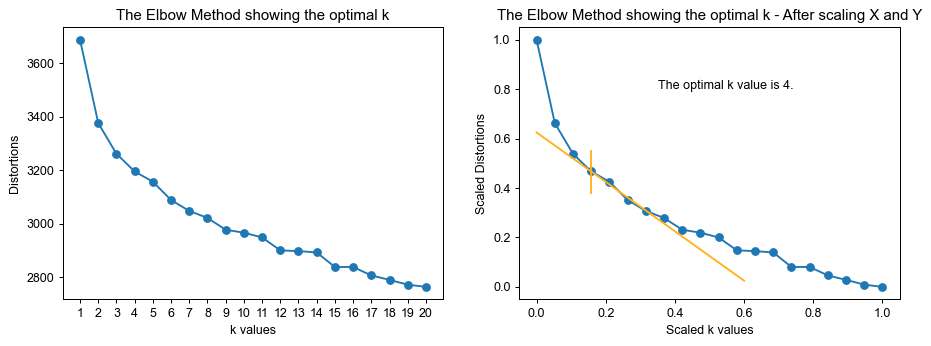

In [50]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
######################################################################
ax1.plot(k_values, distortions, '-o')
ax1.set_xlabel('k values')
ax1.set_ylabel('Distortions')
ax1.set_title('The Elbow Method showing the optimal k')
ax1.set_xticks(range(1, 21))
######################################################################
# MinMaxScaler for k values and distrotions to determine elbow point
######################################################################
data=[[x1, x2] for x1, x2 in zip(k_values, distortions)]
scaler=MinMaxScaler()
scaler.fit(data)
scaler_data=scaler.transform(data)
ax2.plot([x[0] for x in scaler_data], [y[1] for y in scaler_data], '-o')
ax2.plot([0, 0.6], [[x[0]+x[1] for x in scaler_data][3]-y for y in [0, 0.6]], c=(1, 0.7, 0.09))
ax2.plot([[x[0] for x in scaler_data][3], [x[0] for x in scaler_data][3]], [0.38, 0.55], c=(1, 0.7, 0.09))
ax2.set_xlabel('Scaled k values')
ax2.set_ylabel('Scaled Distortions')
ax2.set_title('The Elbow Method showing the optimal k - After scaling X and Y')
ax2.text(0.35, 0.8, 'The optimal k value is 4.')
######################################################################
plt.show()

The optimal k value is determined to be 4 after performing the elbow method [7]. Next we are going to perform k-means clustering with a cluster number of 4 on ingredients, and visualized the result by principal component analysis. Also we are going to explore the relationship between clusters and recipe scores. 

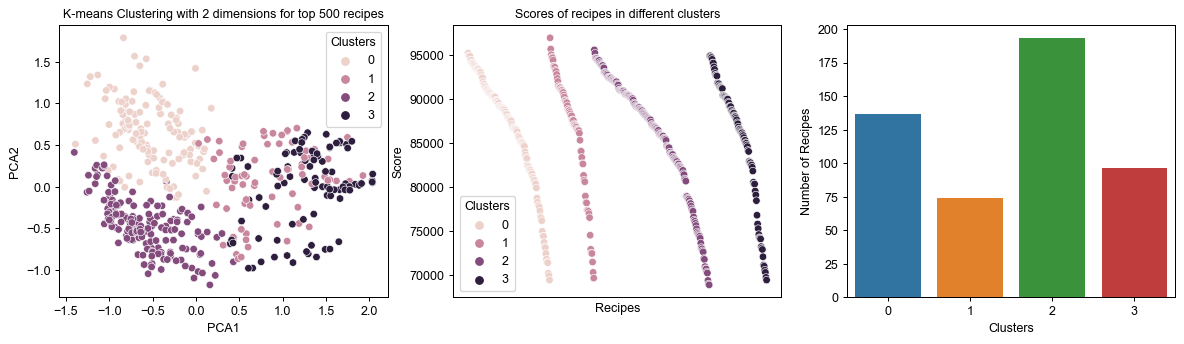

In [51]:
###################################################################################
# Performing  k-means clustering with  and PCA analysis to reduce to 2 dimensions
###################################################################################
fig, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(16, 4))
###################################################################################
kmeans=KMeans(n_clusters=4)
cluster_no_score['Clusters']=kmeans.fit_predict(cluster_no_score)
pca_cluster_no_score=cluster_no_score.drop(columns='Clusters')
reduced_data=PCA(n_components=min(pca_cluster_no_score.shape[0], pca_cluster_no_score.shape[1])).fit_transform(pca_cluster_no_score)
results=pd.DataFrame(reduced_data).iloc[:, 0:2]
results.columns=['PCA1', 'PCA2']
results['Clusters']=cluster_no_score['Clusters'].values
sns.scatterplot(x=results["PCA1"], y=results["PCA2"], hue=results['Clusters'], ax=ax1)
ax1.set_title('K-means Clustering with 2 dimensions for top 500 recipes', fontsize=10)
######## Scores #########################################
data=cluster
score_cluster=pd.concat([data['Score'].reset_index(), pd.DataFrame({'Clusters': results['Clusters']})], axis=1)
data=score_cluster.sort_values(by=['Clusters', 'Score'], ascending=[True, False]).reset_index()
sns.scatterplot(x=data.index, y=data['Score'], hue=data['Clusters'], ax=ax2)
ax2.set_xticks([])
ax2.set_xticks([], minor=True)
ax2.set_xlabel('Recipes')
ax2.set_title('Scores of recipes in different clusters', fontsize=10)
####### Number of recipes in each cluster ###############
bar=data.groupby('Clusters').count().reset_index()
sns.barplot(data=bar, x='Clusters', y='RecipeID', ax=ax3)
ax3.set_ylabel('Number of Recipes')
#########################################################
plt.show()

The first two dimensions of principal component analysis exhibit that the top 500 recipes have been separated into four groups regarding ingredients, indicating that they might from different types of cuisines or from different regions of the world. Moreover, the recipe scores are evenly distributed in each cluster. The qualities of each type of recipes exhibit no significant difference. Not any type of recipes prevails (but if considering the number of recipes which are in top 500, one of the clusters significantly wins out). Therefore we may treat these four types of recipes evenly.

Now we use NLP topic modeling (here we use Latent Dirichlet Allocation: LDA algorithm) to explore the topics of top 500 recipes regarding both names and ingredients. Firstly we create vocabulary of all the words, and then we use LDA to create topics along with the probability distribution for each word in our vocabulary for each topic [6, 8, 9]. 

In [52]:
data=cluster
def remove_non_ingredient_words(string, non_ingredient_words):
    words=[word for word in gensim.utils.simple_preprocess(str(string), deacc=True) if word not in non_ingredient_words]
    return ' '.join(words).strip()
lda_data=data[['Score']].merge(recipes[['RecipeID', 'Recipe Name', 'Ingredients']].set_index('RecipeID'), how='left', on='RecipeID')
text0=pd.DataFrame(lda_data['Recipe Name']+' '+lda_data['Ingredients'], columns=['Text'])
text1=pd.DataFrame(text0['Text'].str.replace(r'[0-9]+', '').str.replace(r'[\(\[].*?[\)\]]', ''))
text2=pd.DataFrame(text1['Text'].str.replace(',', '').str.replace('/', '').str.replace('*', ''))
text=pd.DataFrame(text2['Text'].apply(lambda x: remove_non_ingredient_words(x, non_ingredient_words)))
stop_words=stopwords.words('english')
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
lda_data=text['Text'].values.tolist()
data_words=list(sent_to_words(lda_data))
data_words=remove_stopwords(data_words)
id2word=corpora.Dictionary(data_words)
corpus=[id2word.doc2bow(text) for text in data_words]
#####################################################
# Finding optimal number of topics
#####################################################
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values=[]
    model_list=[]
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
#####################################################################
model_list, coherence_values=compute_coherence_values(dictionary=id2word,
                                                      corpus=corpus,
                                                      texts=data_words,
                                                      start=2, limit=20, step=2)

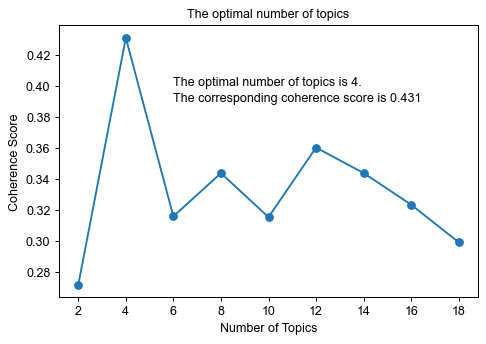

In [56]:
x=range(2, 20, 2)
fig, ax1=plt.subplots(1, 1, figsize=(6, 4))
######################################################################
ax1.plot(x, coherence_values, '-o')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_title('The optimal number of topics', fontsize=10)
ax1.set_xticks(x)
ax1.text(6, 0.4, 'The optimal number of topics is 4.')
ax1.text(6, 0.39, 'The corresponding coherence score is {:.3f}'.format(coherence_values[1]))
######################################################################
plt.show()

In [57]:
######################################################
# Build the LDA model
######################################################
lda_model=gensim.models.LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=4)
pprint(lda_model.print_topics())

[(0,
  '0.036*"sugar" + 0.021*"salt" + 0.020*"oil" + 0.019*"butter" + '
  '0.019*"pepper" + 0.016*"flour" + 0.015*"brown" + 0.014*"purpose" + '
  '0.014*"cheese" + 0.013*"chocolate"'),
 (1,
  '0.036*"butter" + 0.027*"pepper" + 0.026*"flour" + 0.025*"chicken" + '
  '0.025*"cheese" + 0.025*"sugar" + 0.023*"salt" + 0.019*"cream" + '
  '0.018*"purpose" + 0.017*"onion"'),
 (2,
  '0.036*"sugar" + 0.029*"butter" + 0.029*"salt" + 0.026*"chicken" + '
  '0.024*"cheese" + 0.023*"pepper" + 0.021*"garlic" + 0.018*"cream" + '
  '0.017*"baking" + 0.017*"vanilla"'),
 (3,
  '0.041*"sugar" + 0.039*"flour" + 0.032*"salt" + 0.028*"baking" + 0.024*"oil" '
  '+ 0.023*"vanilla" + 0.023*"purpose" + 0.020*"eggs" + 0.019*"powder" + '
  '0.017*"extract"')]


In [58]:
print('The perplexity of the LDA model is: {:.3f}'.format(lda_model.log_perplexity(corpus)))

The perplexity of the LDA model is: -5.961


In [59]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.053617 -0.015310       1        1  33.625023
3     -0.080061 -0.014246       2        1  29.068003
2      0.022418 -0.023853       3        1  24.841467
0      0.004027  0.053408       4        1  12.465503, topic_info=          Term        Freq       Total Category  logprob  loglift
164  chocolate   78.000000   78.000000  Default  30.0000  30.0000
48      cheese  178.000000  178.000000  Default  29.0000  29.0000
6        sugar  354.000000  354.000000  Default  28.0000  28.0000
54      pepper  200.000000  200.000000  Default  27.0000  27.0000
150    chicken  181.000000  181.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
7       baking   14.048066  177.981277   Topic4  -4.5410  -0.4570
127     powder   12.859765  152.178329   Topic4  -4.6294  -0.3887
18     vanilla   12.245758  148.275101   Topic4  -4.6783  -0.4117
136      cream   10.737351  155.779922   Topic4  -4.8097  -0.5925
16        soda    8.989900  100.204239   Topic4  -4.9874  -0.3289

[320 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
119       2  0.637560   allspice
293       1  0.664699      apple
293       2  0.265879      apple
293       3  0.066470      apple
546       1  0.266960  artichoke
...     ...       ...        ...
586       3  0.905867      wings
43        1  0.269812   zucchini
43        2  0.269812   zucchini
43        3  0.089937   zucchini
43        4  0.359750   zucchini

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

We can see that topics are separated well except two of them are overlapped. The separation of topics indicates these recipes have different styles, as k-means clustering described. Because no one topic is significantly larger or smaller in the intertopic distance map, the conclusion remains the same: we may treat each type of recipes evenly.

### Modeling and Prediction

Due to special nature of the data set, some popular algorithms like k-NN or random forests may not work very well in this case. The ingredients data set has 3542 dimensions, that makes k-NN algorithm can hardly find any neighbours in this high dimensional space. For each recipe, only 7~8 ingredient columns have a value of 1, and the rest of the vast majority of the columns have a value of 0. When random forests algorithm randomly picks up features to grow trees, it is hard to pick any useful information: in most cases the random forests just pick features that only contain 0!

Support Vector Machine (SVM) is well known for its effectiveness in high dimensional spaces. SVM may be a good starter. In the mean time, we are also going to use logistic regression, AdaBoost, gradient boosting, XGBoost, lightGBM, CatBoost, and deep learning as well, make comparison, and find the best algorithm for this specific task.

In [2]:
############################################################
# Load data
############################################################
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\scores.pkl', 'rb') as file:
    scores=pickle.load(file)
with open('..\\data\\processed\\ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
with open('..\\data\\processed\\methods.pkl', 'rb') as file:
    methods=pickle.load(file)
data0=ingredients.set_index('RecipeID').merge(methods, how='left', on='RecipeID')
data1=data0.merge(scores[['Score']], how='left', on='RecipeID')
data=data1
data.shape

(8908, 3580)

In [3]:
data['Label']=data['Score'].apply(lambda x: 1 if x>=40000 else 0)
data.Label.mean()
data.iloc[:5, -5:]

,heat,stew,fry,Score,Label
RecipeID,,,,,
7000,0,0,0,24425,0
7001,0,0,0,8475,0
7003,0,0,0,7850,0
7009,0,0,0,5725,0
7010,0,0,0,11425,0


It seems that only 10.5% of the recipes are good ones, and the algorithms will suffer from the problem of imbalanced classes. We can do under-sampling, which means we are going to delete recipes from the over-represented class (bad recipes). Also we are going to delete all the features which only contain 0.

In [4]:
data=data.sort_values('Score', ascending=False).iloc[:3000]
data=data.loc[:, (data!=0).any(axis=0)]
data=data.sample(frac=1)
pd.DataFrame({'Rows': [data.shape[0]], 
              'Columns': [data.shape[1]], 
              'Percentage of good recipes': ['{:.2f}%'.format(data.Label.mean()*100)]})

,Rows,Columns,Percentage of good recipes
0,3000,1991,31.07%


In [5]:
##########################################
# A function to display model performance
##########################################
def display(model, X_test, y_test, data):
    """Display results of a model."""
    y_pred=model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    best_params=pd.DataFrame({key: [value] for key, value in model.best_params_.items()})
    best_params['Best Parameters']='Value'
    best_params=best_params.set_index('Best Parameters').T
    print('-----------------------------------------------------------------------')
    print(best_params)
    print('-----------------------------------------------------------------------')
    cm=confusion_matrix(y_test, y_pred)
    conf_matr=pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T
    print(conf_matr)
    print('-----------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    print('-----------------------------------------------------------------------')
    print('Best train score is {:.2f}'.format(model.best_score_))
    print('AUC score for test set: {:.2f}'.format(roc_auc_score(y_test, y_pred_prob)))
    print('-----------------------------------------------------------------------')

    fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 4))
    X_test1=X_test.join(data['Label'], how='left')
    X_test1['Label_predict']=y_pred
    _=ax1.scatter(X_test1.sort_values('Label', ascending=False).reset_index().index,
          X_test1.sort_values('Label', ascending=False)['Label'], label='Label', s=2)
    _=ax1.scatter(X_test1.sort_values('Label', ascending=False).reset_index().index,
          X_test1.sort_values('Label', ascending=False)['Label_predict']+0.03, 
              label='Predicted Label', s=2)
    _=ax1.legend(frameon=False)
    _=ax1.set_xticks([])
    _=ax1.set_yticks([0.015, 1.015])
    _=ax1.set_yticklabels(['Bad Recipes', 'Good Recipes'])
    _=ax1.set_xlabel('Recipes')
    _=ax1.set_title('Prediction result on test data set')
    fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
    _=ax2.plot([0, 1], [0, 1], 'k--')
    _=ax2.plot(fpr, tpr)
    _=ax2.set_xlabel('False Positive Rate')
    _=ax2.set_ylabel('True Positive Rate')
    _=ax2.set_title('ROC curve')
    plt.show()

We would like to try our best to avoid false positive, since when we get a potential good new recipe, we really want it to be a good recipe. So we are going to use true value precision score as the score for selecting the best models.

#### Support Vector Machine (SVM)

-----------------------------------------------------------------------
Best Parameters Value
C                   1
degree              9
gamma             0.5
kernel           poly
probability      True
-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             38             242              42            578
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       620
           1       0.47      0.14      0.21       280

    accuracy                           0.68       900
   macro avg       0.59      0.53      0.51       900
weighted avg       0.63      0.68      0.62       900

-----------------------------------------------------------------------
Best train score is 0.29
AUC score for test set: 0.57
---------------------------------------------------------------

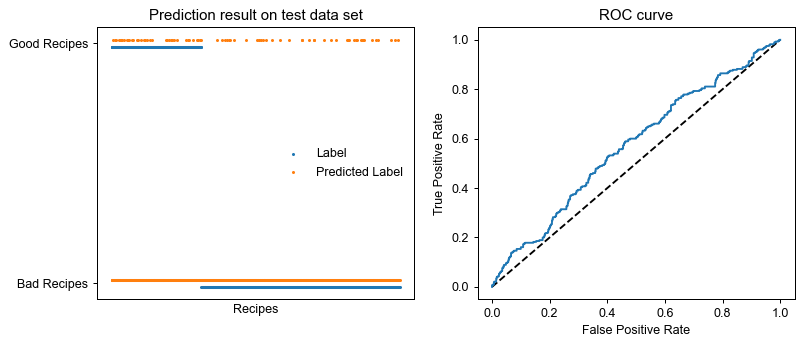

In [6]:
#########################################
# Train test split by 70/30
#########################################
X_train, X_test, y_train, y_test=train_test_split(data.drop(columns=['Score', 'Label']),
                                                 data.Label,
                                                 test_size=0.3,
                                                 random_state=47)
#########################################
# Hyperparameter tuning
#########################################
parameters={
    'C': [1],
    'degree': [9],
    'gamma': [0.5],
    'kernel': ['poly'],
    'probability': [True]
}
svm=GridSearchCV(SVC(), 
                 param_grid=parameters, 
                 cv=5, 
                 n_jobs=-1, 
                 return_train_score=True, 
                 scoring=make_scorer(precision_score, greater_is_better=True,  pos_label=1))
##########################################
# SVM fit and predict
##########################################
svm.fit(X_train, y_train)
_=display(svm, X_test, y_test, data)

In [ ]:
#########################################
# Train test split by 70/30
#########################################
X_train, X_test, y_train, y_test=train_test_split(data.drop(columns=['Score', 'Label']),
                                                 data.Label,
                                                 test_size=0.3,
                                                 random_state=47)
#########################################
# Hyperparameter tuning
#########################################
parameters={
    'C': [1, 10, 100],
    'degree': [9, 15],
    'gamma': [0.5, 1],
    'kernel': ['poly', 'rbf'],
    'probability': [True]
}
svm=GridSearchCV(SVC(), 
                 param_grid=parameters, 
                 cv=5, 
                 n_jobs=-1, 
                 return_train_score=True, 
                 scoring=make_scorer(precision_score, greater_is_better=True,  pos_label=1))
##########################################
# SVM fit and predict
##########################################
svm.fit(X_train, y_train)
_=display(svm, X_test, y_test, data)

### Conclusion

### References
[1] Kiddon, Chloé, Luke Zettlemoyer, and Yejin Choi. "Globally coherent text generation with neural checklist models." In Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing, pp. 329-339. 2016.

[2] Majumder, Bodhisattwa Prasad, Shuyang Li, Jianmo Ni, and Julian McAuley. "Generating personalized recipes from historical user preferences." arXiv preprint arXiv:1909.00105 (2019).

[3] https://www.kaggle.com/kanaryayi/recipe-ingredients-and-reviews. 

[4] https://predictivehacks.com/k-means-elbow-method-code-for-python/

[5] https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns

[6] https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

[7] https://datascience.stackexchange.com/questions/57122/in-elbow-curve-how-to-find-the-point-from-where-the-curve-starts-to-rise

[8] https://stackabuse.com/python-for-nlp-topic-modeling/

[9] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
